# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [11]:
!pip list

Package                      Version   Editable project location
---------------------------- --------- ---------------------------------------
absl-py                      1.4.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
cloudpickle                  2.2.1
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
dill                         0.3.6
exceptiongroup               1.2.0
executing                    2.0.1
Farama-Notifications         0.0.4
flatbuffers                  23.3.3
fonttools                    4.39.3
gast                         0.4.0
google-auth                  2.17.2
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.53.0
gym    


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import tensorflow as tf
import os

In [13]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [14]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [15]:
import cv2
import imghdr

In [16]:
data_dir = 'data' 

In [17]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [18]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 311 files belonging to 2 classes.


In [21]:
data_iterator = data.as_numpy_iterator()

In [22]:
batch = data_iterator.next()

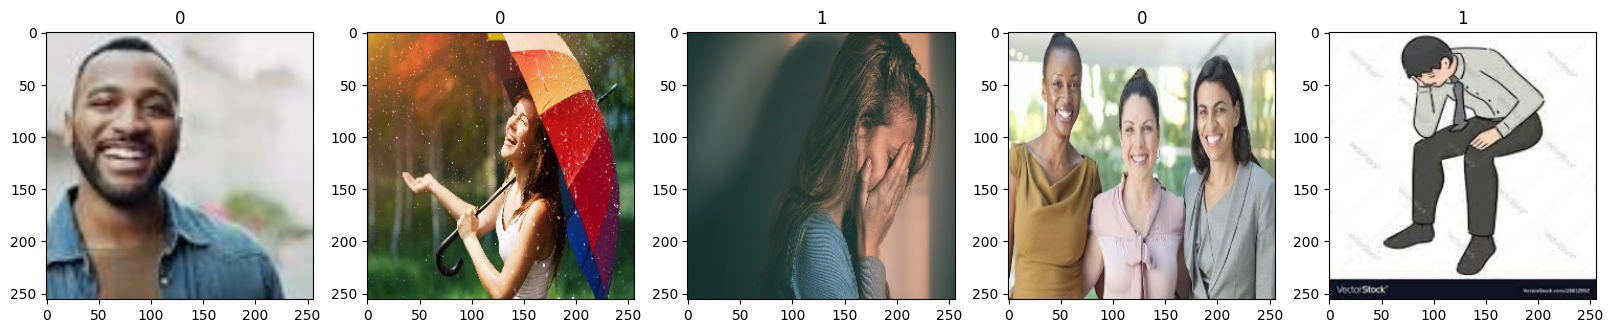

In [23]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [24]:
data = data.map(lambda x,y: (x/255, y))

In [25]:
data.as_numpy_iterator().next()

(array([[[[0.63576806, 0.54135835, 0.37274912],
          [0.6585842 , 0.5513662 , 0.38560623],
          [0.65944684, 0.5535644 , 0.384937  ],
          ...,
          [0.74673235, 0.6543505 , 0.6399309 ],
          [0.77112633, 0.6918562 , 0.6865493 ],
          [0.5719076 , 0.58523476, 0.57294923]],
 
         [[0.6328738 , 0.5392588 , 0.36670974],
          [0.6619112 , 0.5545209 , 0.39041725],
          [0.6551442 , 0.5492618 , 0.3806344 ],
          ...,
          [0.7475758 , 0.6462297 , 0.6414503 ],
          [0.7365407 , 0.6342936 , 0.63189054],
          [0.7074755 , 0.65270853, 0.6504969 ]],
 
         [[0.64936715, 0.5552495 , 0.38270047],
          [0.65891355, 0.55303115, 0.38440374],
          [0.6540441 , 0.54816175, 0.3795343 ],
          ...,
          [0.74018747, 0.63272923, 0.62461513],
          [0.74482805, 0.64342064, 0.6351792 ],
          [0.74249196, 0.6657983 , 0.6706581 ]],
 
         ...,
 
         [[0.1124799 , 0.11002892, 0.10653627],
          [0.10729

# 5. Split Data

In [26]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [27]:
train_size

7

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [30]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [32]:
model = Sequential()

In [33]:
# First Convolution Block has 16 filters 3x3 pixels and moves 1 pixel at a time using activation map - ReLU
# The first layer needs a size for the images - 256x256 pixels with 3 channels
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Condenses information from 2x2 blocks
model.add(MaxPooling2D())

# Another block with 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# The last block with 16 filters
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flattening the values into one dimention
model.add(Flatten())

# 256 output neurons for the Dense layer
model.add(Dense(256, activation='relu'))
# 1 output for the final Dense layer with sigmoid activation map - values between 0 and 1 (0=happy, 1=sad)
model.add(Dense(1, activation='sigmoid'))

In [34]:
# Compile the model with 'adam' optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 8s 816ms/step - loss: 1.1403 - accuracy: 0.4866 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 6s 724ms/step - loss: 0.6511 - accuracy: 0.5089 - val_loss: 0.5795 - val_accuracy: 0.6406
Epoch 3/20
7/7 [==============================] - 6s 781ms/step - loss: 0.5844 - accuracy: 0.6741 - val_loss: 0.7278 - val_accuracy: 0.4531
Epoch 4/20
7/7 [==============================] - 7s 781ms/step - loss: 0.5936 - accuracy: 0.7857 - val_loss: 0.4975 - val_accuracy: 0.7969
Epoch 5/20
7/7 [==============================] - 7s 777ms/step - loss: 0.5125 - accuracy: 0.8304 - val_loss: 0.2763 - val_accuracy: 0.9219
Epoch 6/20
7/7 [==============================] - 7s 778ms/step - loss: 0.3090 - accuracy: 0.9018 - val_loss: 0.3881 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 7s 776ms/step - loss: 0.2273 - accuracy: 0.9330 - val_loss: 0.1787 - val_accuracy: 0.9688
Epoch 8/20
7/7 [====

# 8. Plot Performance

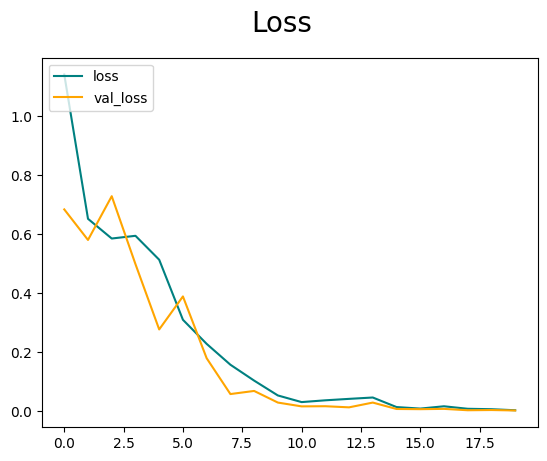

In [39]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

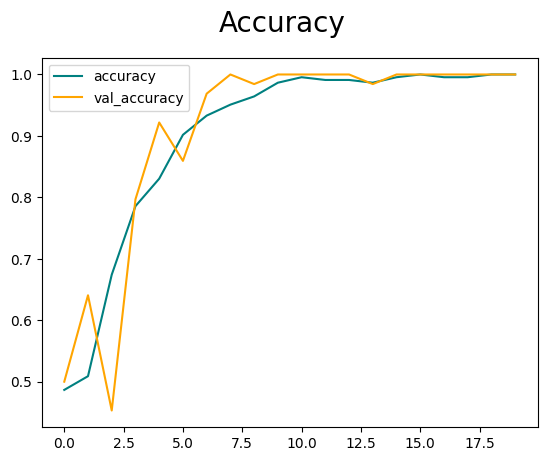

In [40]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [41]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [42]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [43]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 153ms/step


In [44]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [45]:
import cv2

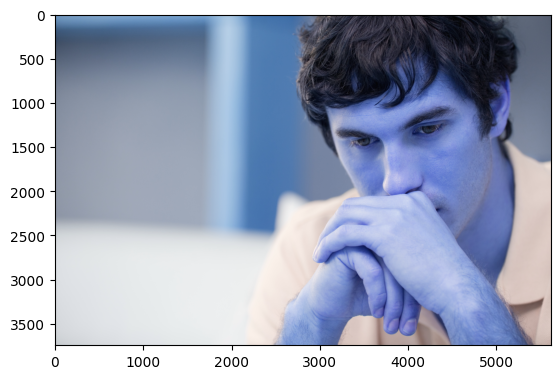

In [46]:
img = cv2.imread('data/sad/8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

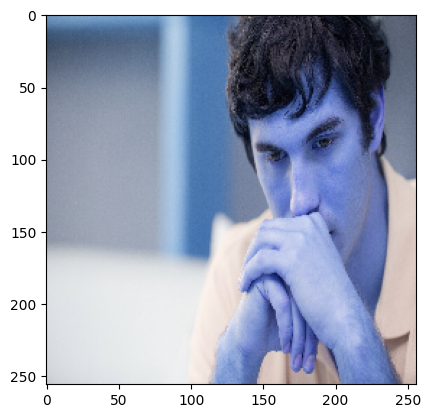

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [49]:
yhat

array([[0.99975157]], dtype=float32)

In [50]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [52]:
model.save(os.path.join('models','cnn.h5'))

# 12. Use the saved Model without training again 

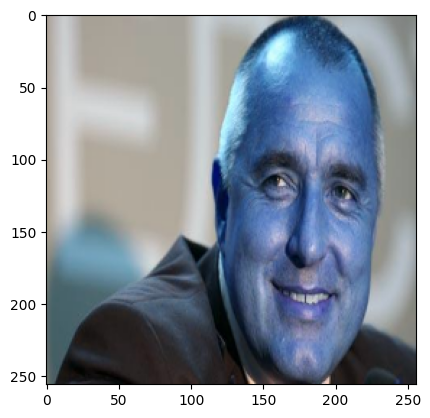

1/1 [==============================] - 0s 61ms/step
Prediction is: Happy


In [54]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
import cv2

img = cv2.imread('data/happy/boyko_happy1.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

new_model = load_model('models/cnn.h5')
yhat = new_model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5: 
    print(f'Prediction is: Sad')
else:
    print(f'Prediction is: Happy')